# Part 1: 
In your project you have been working with a bias dataset. Most probabely suupervised models were underfit. You should remember that this is a real dataset, and in real life most of the time you dont have access to clean and unbias dataset. In situations like this, none of the regression models will have a good fit for the dataset due to the large predence of the 0s. In the first part of this take-home exam, you are asked to be creative, and find a solution for this problem. 

For this dataset, you can break the problem, into a two-step machine learning model. 

First step is to classify the data points as positive revenue and zero revenue. This simply is a binary classification. You should remember that when you are dealing with biased datasets, accuracy is not a reliable scoring metric. So look for a robust scoring function. 

Next, you need to build a regression model to postprocess classification results. Here is a flow chart to show you the outline of the model. 

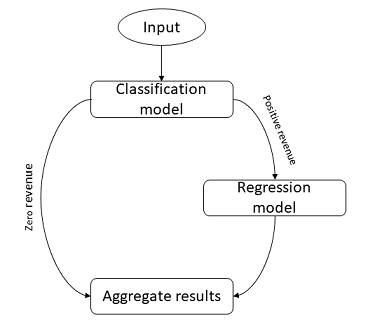

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read in data
data = pd.read_csv("data.csv")

In [3]:
#A significant amount of the transaction data is NaN. It looks like there are only 193 sales.
#A NaN transaction would be 0. if the transaction is 0 the total revenue is also 0.
data['totals_totalTransactionRevenue'] = data['totals_totalTransactionRevenue'].fillna(0)
data['totals_transactionRevenue'] = data['totals_transactionRevenue'].fillna(0)
data['totals_transactions'] = data['totals_transactions'].fillna(0)

In [4]:
#function to convert JSON to Dict
def string_to_dict_simple(dict_string):
    return ast.literal_eval(dict_string)

In [5]:
#Custom Dimenstions Column
customDimensionsData = data['customDimensions'].apply(string_to_dict_simple)
customDimensionsDataFrame = pd.DataFrame(list(customDimensionsData))

In [6]:
#Device Data Column
deviceData = data['device'].apply(string_to_dict_simple)
deviceDataFrame = pd.DataFrame(list(deviceData))

In [7]:
#GeoData Column
geoData = data['geoNetwork'].apply(string_to_dict_simple)
geoDataFrame = pd.DataFrame(list(geoData))

In [8]:
#Traffic Source Column
trafficSourceData = data['trafficSource'].apply(string_to_dict_simple)
trafficSourceDataFrame = pd.DataFrame(list(trafficSourceData))
trafficSourceDataFrame.drop(columns=['adwordsClickInfo'], inplace=True)

In [9]:
#Drop Columns
data.drop(columns=['customDimensions','hits','trafficSource','device','geoNetwork'], inplace=True)

In [10]:
#Add new dataframes as columns
newData = pd.concat([data, deviceDataFrame, geoDataFrame, trafficSourceDataFrame], axis=1)

In [11]:
#Replace not available in demo dataset
newData = newData.replace('not available in demo dataset', np.nan, regex=True)

In [12]:
#Drop columns with NA values
half_count = len(newData) / 2
newData = newData.dropna(thresh=half_count,axis=1)

In [13]:
drop_cols = ['socialEngagementType','networkDomain','campaign','totals_newVisits','totals_timeOnSite']

In [14]:
#Dop columns
newData = newData.drop(drop_cols,axis=1)

In [15]:
#Fill in null data
newData['totals_pageviews'] = data['totals_pageviews'].fillna(1)

In [16]:
#Create simple data set just in case
newDataSimple = newData.filter(['date','browser','totals_visits','totals_totalTransactionRevenue'], axis=1)

In [17]:
#converting complex data set
nominal_columns = ["channelGrouping","browser","deviceCategory","isMobile","operatingSystem","continent","country","subContinent","medium","source"]
dummy_df = pd.get_dummies(newData[nominal_columns])
newData = pd.concat([newData, dummy_df], axis=1)
newData = newData.drop(nominal_columns, axis=1)

In [18]:
#Converting simple data set
nominal_columns = ["browser"]
dummy_df = pd.get_dummies(newDataSimple[nominal_columns])
newDataSimple = pd.concat([newDataSimple, dummy_df], axis=1)
newDataSimple = newDataSimple.drop(nominal_columns, axis=1)

In [19]:
#Save off copy of data just in case
newDataCopy = newData.copy()
newDataSimpleCopy = newDataSimple.copy()

In [20]:
X = newData.drop(['totals_totalTransactionRevenue'], axis=1)

In [21]:
y = newData['totals_totalTransactionRevenue']

In [22]:
from sklearn.cross_validation import train_test_split

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

In [24]:
from sklearn.naive_bayes import GaussianNB

In [25]:
model = GaussianNB()

In [26]:
model.fit(Xtrain, ytrain)

GaussianNB(priors=None)

In [27]:
y_model = model.predict(X)

In [28]:
y_model.shape

(20000,)

In [29]:
X['predicted'] = y_model

In [30]:
salesData = X[X.predicted > 0] 

In [31]:
salesData.shape

(287, 329)

In [32]:
#Run regression model

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
X2 = salesData.drop(['predicted'], axis=1)

In [35]:
y2 = salesData['predicted']

In [36]:
model = LinearRegression(fit_intercept=False)

In [37]:
model.fit(X2, y2)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [38]:
salesData['new_prediction'] = model.predict(X2)

C:\Users\Mike\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


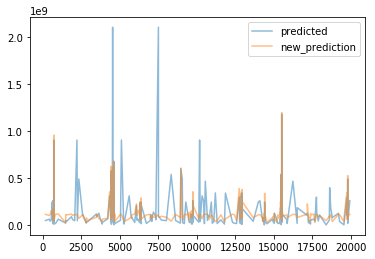

In [39]:
salesData[['predicted','new_prediction']].plot(alpha=0.5)

# Part 2
In this part you will create a Python function ``plot_decision_boundary`` that will accepts a machine learning model, feature set ``X``, and target set ``y`` as input and will plot the decision boundary of the input machine learning model  on ``(X,y)``. The following is a sample run of this function: 

```Python
%matplotlib inline
# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training a classifier
svm = SVC(C=0.5, kernel='linear')
svm.fit(X, y)

# Plotting decision boundary
plot_decision_boundary(X, y, clf=svm)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')```

Sample output: 
![decision_boundary.png](attachment:decision_boundary.png)

In [40]:
#adding necessary imports
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC

In [41]:
from itertools import cycle
import numpy as np
from math import floor
from math import ceil

def plot_decision_boundary(X, y, clf):
  
    dim = X.shape[1]
    print("Dim" + str(dim))
    
    colors=('#1f77b4,#ff7f0e,#3ca02c,#d62728,#9467bd,#8c564b,#e377c2,#7f7f7f,#bcbd22,#17becf')
    markers='s^oxv<>'
    ax = plt.gca()

    plot_testdata = True
    feature_index = (0, 1)
    x_index, y_index = feature_index

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = X[:, x_index].min() - 1, X[:, x_index].max() + 1
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = X[:, y_index].min() - 1, X[:, y_index].max() + 1

    xnum, ynum = plt.gcf().dpi * plt.gcf().get_size_inches()
    xnum, ynum = floor(xnum), ceil(ynum)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=xnum),
                         np.linspace(y_min, y_max, num=ynum))

    if dim == 1:
        X_predict = np.array([xx.ravel()]).T
    else:
        X_grid = np.array([xx.ravel(), yy.ravel()]).T
        X_predict = np.zeros((X_grid.shape[0], dim))
        X_predict[:, x_index] = X_grid[:, 0]
        X_predict[:, y_index] = X_grid[:, 1]
        if dim > 2:
            for feature_idx in filler_feature_values:
                X_predict[:, feature_idx] = filler_feature_values[feature_idx]
    Z = clf.predict(X_predict.astype(X.dtype))
    Z = Z.reshape(xx.shape)
    
    # Plot decision region
    cset = ax.contourf(xx, yy, Z,
                       colors=colors,
                       levels=np.arange(Z.max() + 2) - 0.5,
                       antialiased=True,
                       alpha=0.45)

    ax.contour(xx, yy, Z, cset.levels,
               colors='k',
               linewidths=0.5,
               alpha=0.45,
               antialiased=True)

    ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())

    # Scatter training data samples
    for idx, c in enumerate(np.unique(y)):
        if dim == 1:
            y_data = [0 for i in X[y == c]]
            x_data = X[y == c]
        elif dim == 2:
            y_data = X[y == c, y_index]
            x_data = X[y == c, x_index]
        elif dim > 2 and filler_feature_ranges is not None:
            class_mask = y == c
            feature_range_mask = get_feature_range_mask(
                            X, filler_feature_values=filler_feature_values,
                            filler_feature_ranges=filler_feature_ranges)
            y_data = X[class_mask & feature_range_mask, y_index]
            x_data = X[class_mask & feature_range_mask, x_index]
        else:
            continue

        ax.scatter(x=x_data,
                   y=y_data,
                   c=colors[idx],
                   marker=next(marker_gen),
                   label=c,
                   edgecolor='black',
                   alpha=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, framealpha=0.3, scatterpoints=1, loc=1)

    return ax

Dim2


Text(0.5,1,'SVM on Iris')

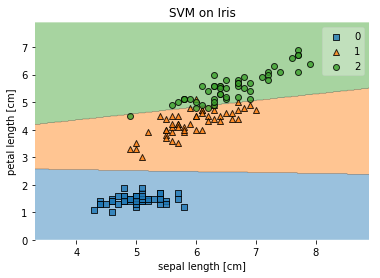

In [42]:
%matplotlib inline
# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training a classifier
svm = SVC(C=0.5, kernel='linear')
svm.fit(X, y)

# Plotting decision boundary
plot_decision_boundary(X, y, clf=svm)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')